In [193]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np,cupy as cp, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)

from scipy.optimize import curve_fit

import misc_util

In [2]:
data_dihadrons = uproot3.open('../in/data_dihadrons_30pc.root')['dihadrons'].pandas.df()

In [3]:
mc_dihadrons = uproot3.open('../in/mc_dihadrons.root')['dihadrons'].pandas.df()

In [4]:
data_triggers = pd.read_pickle('../in/data_hadrons_trigger_30pc.pkl')

In [ ]:
data_hadrons = uproot3.open('../in/data_hadrons_30pc.root')['hadrons'].pandas.df()

In [111]:
mc_hadrons = uproot3.open('../in/mc_hadrons_new.root')['hadrons'].pandas.df()

In [5]:
len(data_dihadrons)

1672821

In [70]:
import ROOT
masses = {211: 0.13957018, -211: 0.13957018, 321: 0.493677, -321: 0.493677, 2212: 0.93827208816, -2212: 0.93827208816}
def to_cm(E, e_px, e_py, e_pz, h_px, h_py, h_pz,h_pid):
    beam = ROOT.TLorentzVector()
    beam.SetPxPyPzE(0,0,E,E)
    electron = ROOT.TLorentzVector()
    electron.SetPxPyPzE(e_px,e_py,e_pz,np.sqrt(0.000511**2+e_px**2+e_py**2+e_pz**2))
    target = ROOT.TLorentzVector()
    target.SetPxPyPzE(0,0,0,masses[2212])
    virtual_photon = beam-electron
    cm = virtual_photon+target
    hadron = ROOT.TLorentzVector(h_px,h_py,h_pz, np.sqrt(masses[h_pid]**2+h_px**2+h_py**2+h_pz**2))
                                                                                                      
    hadron.RotateZ(-cm.Phi());
    hadron.RotateY(-cm.Theta());
    hadron.Boost(0,0,-cm.Beta());
    return hadron.Pt(),hadron.Rapidity(),hadron.Phi();
    

In [335]:
#new version
def mix_from_singles(df, binvars=''.split(), nbins=1,maxEvents=None, nAssocPerTrigger=1):
    start = time.perf_counter()
    df['h_z'] = df.z
    
    Q2 = df['Q2']
    #try:
    N = len(df)
    if maxEvents != None:
        N = min(N, maxEvents)
    h_pid = df['h_pid']
    partitions = {}
    for var in binvars:
        partitions[var] = [df[var].quantile(i/3) for i in range(nbins+1)]
    df_out = pd.DataFrame()
    
    fields = []
    for name in df.columns:
        if name[:2] == 'h_':
            fields.append(name)
    d = {}
    for name in fields:
        d["h1_" + name[2:]] = []
        d["h2_" + name[2:]] = []
    
    d['diff_phi_cm'] = []
    d['diff_phi_lab'] = []
    d['diff_rap_cm'] = []
    d['diff_eta_cm'] = []
    
    def same_bin(i,j):
        #print("checking ", i, j)
        if Q2[i] == Q2[j] or Q2[i] == 0 or Q2[j] == 0 or h_pid[i] == 0 or h_pid[j] == 0: #don't mix with the same event
            return False
        for var in binvars:
            good = False
            xi = df[var][i]
            xj = df[var][j]
            pvar = partitions[var]
            for b in range(nbins):
                if xi >= pvar[b] and xi < pvar[b+1] and\
                        xj >= pvar[b] and xj < pvar[b+1]:
                    good=True
                    break
            if not good:
                return False
        return True
            
    
    #i = trigger
    #j = associated
    j = 0
    for i in range(N):
        found_mix= 0
        if df['h_z'][i] < 0.5:# or abs(df['h_pid'][i])!= 211:
            continue
        #print('check1')
        for ii in range(nAssocPerTrigger):
            for k in range(100):
                #print("check2")
                j += 1
                if j >= N:
                    j = 0
                #if df['h_z'][j] > df['h_z'][i]:
                #    continue;
                if same_bin(i,j):
                    found_mix = k+1
                    break
            
            #print("check3")
            if found_mix == 0:
                continue
            #print("check4")
            for name in fields:
                if name[:2] == 'h_':
                    d["h1_" + name[2:]].append(df[name][i])
                    if not 'cm' in name and not '_z' in name:
                        d["h2_" + name[2:]].append(df[name][j])
                else :
                    d[name].append(df[name][i])

            d['diff_phi_lab'].append(df.h_ph[i]-df.h_ph[j] 
                                    + 2*np.pi*(df.h_ph[i]-df.h_ph[j]<-np.pi)
                                    -2*np.pi*(df.h_ph[i]-df.h_ph[j]>np.pi))
            #for the cm variables, use the trigger particle's electron info to get the cm frame
            pt,rap,phi = to_cm(df.E[i], df.e_px[i], df.e_py[i], df.e_pz[i],df.h_px[j], df.h_py[j], df.h_pz[j],df.h_pid[j])
            d["h2_cm_pt"].append(pt)
            d["h2_cm_rap"].append(rap)
            d["h2_cm_ph"].append(phi)
            d["h2_z"].append(df.h_z[j]*df.nu[j]/df.nu[i])
            
            d['diff_phi_cm'].append(df.h_cm_ph[i]-phi 
                                    + 2*np.pi*(df.h_cm_ph[i]-phi<-np.pi)
                                    -2*np.pi*(df.h_cm_ph[i]-phi>np.pi))

            d['diff_rap_cm'].append(df.h_cm_rap[i]-rap)
            #d['diff_eta_cm'].append(df.h_cm_eta[i]-df.h_cm_eta[j])

            if i % 10000 == 0:
                duration = time.perf_counter()-start
                print("%.1f"%(i/N*100),"% complete, time so far: ",duration//3600,"hours", 
                      (duration//60)%60, "minutes", int(duration % 60), "seconds")

    
    
    duration = time.perf_counter()-start
    print("total time: ",duration//3600,"hours", (duration//60)%60, "minutes", int(duration % 60), "seconds")
    #os.system('say "your program has finished"')
    #print("%.5f"%(100*np.mean(df['mix_found']!=0)),"% of the events have been mixed")
    for key in list(d.keys()):
        print(key, len(d[key]))
        if len(d[key])==0:
            del d[key]
    ret = pd.DataFrame.from_dict(d)
    ret['diff_phi_lab'] = ret.h1_ph - ret.h2_ph + 2*np.pi*(ret.h1_ph-ret.h2_ph<-np.pi)-2*np.pi*(ret.h1_ph-ret.h2_ph>np.pi)
    return ret

In [ ]:
mixed = mix_from_singles(data_hadrons,nAssocPerTrigger=1)


0.2 % complete, time so far:  0.0 hours 0.0 minutes 23 seconds
0.2 % complete, time so far:  0.0 hours 0.0 minutes 34 seconds
0.5 % complete, time so far:  0.0 hours 1.0 minutes 9 seconds
0.5 % complete, time so far:  0.0 hours 1.0 minutes 17 seconds
0.6 % complete, time so far:  0.0 hours 1.0 minutes 25 seconds
0.6 % complete, time so far:  0.0 hours 1.0 minutes 27 seconds
0.6 % complete, time so far:  0.0 hours 1.0 minutes 31 seconds
0.8 % complete, time so far:  0.0 hours 1.0 minutes 54 seconds
0.8 % complete, time so far:  0.0 hours 1.0 minutes 58 seconds
0.9 % complete, time so far:  0.0 hours 2.0 minutes 10 seconds
0.9 % complete, time so far:  0.0 hours 2.0 minutes 20 seconds
1.0 % complete, time so far:  0.0 hours 2.0 minutes 28 seconds
1.1 % complete, time so far:  0.0 hours 2.0 minutes 42 seconds
1.1 % complete, time so far:  0.0 hours 2.0 minutes 48 seconds
1.3 % complete, time so far:  0.0 hours 3.0 minutes 26 seconds
1.4 % complete, time so far:  0.0 hours 3.0 minutes 34 s

In [169]:
pd.to_pickle(mixed, "../in/data_dihadrons_mixed_30pc.pkl")
print(len(mixed)/len(data_dihadrons))

7.028297110091277


In [181]:
print(len(mixed)/len(data_dihadrons))

7.028297110091277


In [114]:
pd.to_pickle(mc_hadrons.query("Q2>0"), "../in/mc_hadrons_recon.pkl")
mc_hadrons_recon = pd.read_pickle( "../in/mc_hadrons_recon.pkl")

In [125]:
mc_mixed = mix_from_singles(mc_hadrons,maxEvents=None)

0.0 % complete, time so far:  0.0 hours 0.0 minutes 0 seconds
0.1 % complete, time so far:  0.0 hours 0.0 minutes 0 seconds
0.1 % complete, time so far:  0.0 hours 0.0 minutes 0 seconds
0.1 % complete, time so far:  0.0 hours 0.0 minutes 0 seconds
0.1 % complete, time so far:  0.0 hours 0.0 minutes 0 seconds
0.4 % complete, time so far:  0.0 hours 0.0 minutes 1 seconds
0.4 % complete, time so far:  0.0 hours 0.0 minutes 1 seconds
0.6 % complete, time so far:  0.0 hours 0.0 minutes 3 seconds
0.7 % complete, time so far:  0.0 hours 0.0 minutes 3 seconds
0.7 % complete, time so far:  0.0 hours 0.0 minutes 3 seconds
0.7 % complete, time so far:  0.0 hours 0.0 minutes 3 seconds
0.8 % complete, time so far:  0.0 hours 0.0 minutes 4 seconds
0.9 % complete, time so far:  0.0 hours 0.0 minutes 4 seconds
0.9 % complete, time so far:  0.0 hours 0.0 minutes 4 seconds
0.9 % complete, time so far:  0.0 hours 0.0 minutes 4 seconds
1.1 % complete, time so far:  0.0 hours 0.0 minutes 5 seconds
1.1 % co

11.1 % complete, time so far:  0.0 hours 0.0 minutes 57 seconds
11.2 % complete, time so far:  0.0 hours 0.0 minutes 58 seconds
11.3 % complete, time so far:  0.0 hours 0.0 minutes 58 seconds
11.6 % complete, time so far:  0.0 hours 1.0 minutes 0 seconds
11.8 % complete, time so far:  0.0 hours 1.0 minutes 1 seconds
11.8 % complete, time so far:  0.0 hours 1.0 minutes 1 seconds
11.9 % complete, time so far:  0.0 hours 1.0 minutes 1 seconds
11.9 % complete, time so far:  0.0 hours 1.0 minutes 2 seconds
11.9 % complete, time so far:  0.0 hours 1.0 minutes 2 seconds
11.9 % complete, time so far:  0.0 hours 1.0 minutes 2 seconds
11.9 % complete, time so far:  0.0 hours 1.0 minutes 2 seconds
11.9 % complete, time so far:  0.0 hours 1.0 minutes 2 seconds
11.9 % complete, time so far:  0.0 hours 1.0 minutes 2 seconds
12.0 % complete, time so far:  0.0 hours 1.0 minutes 2 seconds
12.0 % complete, time so far:  0.0 hours 1.0 minutes 2 seconds
12.0 % complete, time so far:  0.0 hours 1.0 minutes

20.6 % complete, time so far:  0.0 hours 1.0 minutes 48 seconds
20.6 % complete, time so far:  0.0 hours 1.0 minutes 48 seconds
20.7 % complete, time so far:  0.0 hours 1.0 minutes 48 seconds
21.0 % complete, time so far:  0.0 hours 1.0 minutes 50 seconds
21.0 % complete, time so far:  0.0 hours 1.0 minutes 50 seconds
21.2 % complete, time so far:  0.0 hours 1.0 minutes 51 seconds
21.3 % complete, time so far:  0.0 hours 1.0 minutes 51 seconds
21.3 % complete, time so far:  0.0 hours 1.0 minutes 52 seconds
21.4 % complete, time so far:  0.0 hours 1.0 minutes 52 seconds
21.4 % complete, time so far:  0.0 hours 1.0 minutes 52 seconds
21.5 % complete, time so far:  0.0 hours 1.0 minutes 53 seconds
21.5 % complete, time so far:  0.0 hours 1.0 minutes 53 seconds
21.6 % complete, time so far:  0.0 hours 1.0 minutes 53 seconds
21.6 % complete, time so far:  0.0 hours 1.0 minutes 53 seconds
21.7 % complete, time so far:  0.0 hours 1.0 minutes 54 seconds
21.7 % complete, time so far:  0.0 hours

29.5 % complete, time so far:  0.0 hours 2.0 minutes 35 seconds
29.6 % complete, time so far:  0.0 hours 2.0 minutes 36 seconds
29.6 % complete, time so far:  0.0 hours 2.0 minutes 36 seconds
29.7 % complete, time so far:  0.0 hours 2.0 minutes 37 seconds
29.7 % complete, time so far:  0.0 hours 2.0 minutes 37 seconds
29.8 % complete, time so far:  0.0 hours 2.0 minutes 37 seconds
29.8 % complete, time so far:  0.0 hours 2.0 minutes 37 seconds
29.9 % complete, time so far:  0.0 hours 2.0 minutes 38 seconds
30.5 % complete, time so far:  0.0 hours 2.0 minutes 41 seconds
30.5 % complete, time so far:  0.0 hours 2.0 minutes 41 seconds
30.7 % complete, time so far:  0.0 hours 2.0 minutes 42 seconds
30.8 % complete, time so far:  0.0 hours 2.0 minutes 42 seconds
31.0 % complete, time so far:  0.0 hours 2.0 minutes 44 seconds
31.2 % complete, time so far:  0.0 hours 2.0 minutes 45 seconds
31.2 % complete, time so far:  0.0 hours 2.0 minutes 45 seconds
31.2 % complete, time so far:  0.0 hours

39.6 % complete, time so far:  0.0 hours 3.0 minutes 29 seconds
39.6 % complete, time so far:  0.0 hours 3.0 minutes 29 seconds
39.7 % complete, time so far:  0.0 hours 3.0 minutes 30 seconds
39.7 % complete, time so far:  0.0 hours 3.0 minutes 30 seconds
39.8 % complete, time so far:  0.0 hours 3.0 minutes 31 seconds
39.8 % complete, time so far:  0.0 hours 3.0 minutes 31 seconds
40.0 % complete, time so far:  0.0 hours 3.0 minutes 32 seconds
40.1 % complete, time so far:  0.0 hours 3.0 minutes 32 seconds
40.1 % complete, time so far:  0.0 hours 3.0 minutes 32 seconds
40.2 % complete, time so far:  0.0 hours 3.0 minutes 33 seconds
40.3 % complete, time so far:  0.0 hours 3.0 minutes 33 seconds
40.5 % complete, time so far:  0.0 hours 3.0 minutes 34 seconds
40.5 % complete, time so far:  0.0 hours 3.0 minutes 34 seconds
40.6 % complete, time so far:  0.0 hours 3.0 minutes 35 seconds
40.7 % complete, time so far:  0.0 hours 3.0 minutes 35 seconds
40.7 % complete, time so far:  0.0 hours

48.9 % complete, time so far:  0.0 hours 4.0 minutes 19 seconds
49.0 % complete, time so far:  0.0 hours 4.0 minutes 20 seconds
49.0 % complete, time so far:  0.0 hours 4.0 minutes 20 seconds
49.1 % complete, time so far:  0.0 hours 4.0 minutes 20 seconds
49.1 % complete, time so far:  0.0 hours 4.0 minutes 20 seconds
49.2 % complete, time so far:  0.0 hours 4.0 minutes 21 seconds
49.3 % complete, time so far:  0.0 hours 4.0 minutes 21 seconds
49.3 % complete, time so far:  0.0 hours 4.0 minutes 21 seconds
49.3 % complete, time so far:  0.0 hours 4.0 minutes 21 seconds
49.3 % complete, time so far:  0.0 hours 4.0 minutes 22 seconds
49.4 % complete, time so far:  0.0 hours 4.0 minutes 22 seconds
49.5 % complete, time so far:  0.0 hours 4.0 minutes 22 seconds
49.6 % complete, time so far:  0.0 hours 4.0 minutes 23 seconds
49.6 % complete, time so far:  0.0 hours 4.0 minutes 23 seconds
49.6 % complete, time so far:  0.0 hours 4.0 minutes 23 seconds
49.6 % complete, time so far:  0.0 hours

56.8 % complete, time so far:  0.0 hours 5.0 minutes 1 seconds
56.9 % complete, time so far:  0.0 hours 5.0 minutes 2 seconds
56.9 % complete, time so far:  0.0 hours 5.0 minutes 2 seconds
57.1 % complete, time so far:  0.0 hours 5.0 minutes 3 seconds
57.1 % complete, time so far:  0.0 hours 5.0 minutes 3 seconds
57.2 % complete, time so far:  0.0 hours 5.0 minutes 3 seconds
57.2 % complete, time so far:  0.0 hours 5.0 minutes 4 seconds
57.3 % complete, time so far:  0.0 hours 5.0 minutes 4 seconds
57.3 % complete, time so far:  0.0 hours 5.0 minutes 4 seconds
57.4 % complete, time so far:  0.0 hours 5.0 minutes 4 seconds
57.4 % complete, time so far:  0.0 hours 5.0 minutes 5 seconds
57.4 % complete, time so far:  0.0 hours 5.0 minutes 5 seconds
57.5 % complete, time so far:  0.0 hours 5.0 minutes 5 seconds
57.6 % complete, time so far:  0.0 hours 5.0 minutes 6 seconds
57.7 % complete, time so far:  0.0 hours 5.0 minutes 6 seconds
57.8 % complete, time so far:  0.0 hours 5.0 minutes 7 

65.6 % complete, time so far:  0.0 hours 5.0 minutes 48 seconds
65.7 % complete, time so far:  0.0 hours 5.0 minutes 49 seconds
65.8 % complete, time so far:  0.0 hours 5.0 minutes 49 seconds
65.9 % complete, time so far:  0.0 hours 5.0 minutes 50 seconds
66.0 % complete, time so far:  0.0 hours 5.0 minutes 51 seconds
66.1 % complete, time so far:  0.0 hours 5.0 minutes 51 seconds
66.1 % complete, time so far:  0.0 hours 5.0 minutes 51 seconds
66.1 % complete, time so far:  0.0 hours 5.0 minutes 51 seconds
66.2 % complete, time so far:  0.0 hours 5.0 minutes 51 seconds
66.2 % complete, time so far:  0.0 hours 5.0 minutes 52 seconds
66.2 % complete, time so far:  0.0 hours 5.0 minutes 52 seconds
66.3 % complete, time so far:  0.0 hours 5.0 minutes 52 seconds
66.4 % complete, time so far:  0.0 hours 5.0 minutes 53 seconds
66.5 % complete, time so far:  0.0 hours 5.0 minutes 53 seconds
66.6 % complete, time so far:  0.0 hours 5.0 minutes 54 seconds
66.6 % complete, time so far:  0.0 hours

74.8 % complete, time so far:  0.0 hours 6.0 minutes 38 seconds
74.8 % complete, time so far:  0.0 hours 6.0 minutes 38 seconds
74.8 % complete, time so far:  0.0 hours 6.0 minutes 38 seconds
74.9 % complete, time so far:  0.0 hours 6.0 minutes 38 seconds
74.9 % complete, time so far:  0.0 hours 6.0 minutes 38 seconds
75.3 % complete, time so far:  0.0 hours 6.0 minutes 40 seconds
75.3 % complete, time so far:  0.0 hours 6.0 minutes 41 seconds
75.4 % complete, time so far:  0.0 hours 6.0 minutes 41 seconds
75.5 % complete, time so far:  0.0 hours 6.0 minutes 42 seconds
75.5 % complete, time so far:  0.0 hours 6.0 minutes 42 seconds
75.6 % complete, time so far:  0.0 hours 6.0 minutes 42 seconds
75.7 % complete, time so far:  0.0 hours 6.0 minutes 42 seconds
75.8 % complete, time so far:  0.0 hours 6.0 minutes 43 seconds
75.8 % complete, time so far:  0.0 hours 6.0 minutes 43 seconds
75.9 % complete, time so far:  0.0 hours 6.0 minutes 43 seconds
75.9 % complete, time so far:  0.0 hours

83.6 % complete, time so far:  0.0 hours 7.0 minutes 26 seconds
83.6 % complete, time so far:  0.0 hours 7.0 minutes 26 seconds
83.7 % complete, time so far:  0.0 hours 7.0 minutes 26 seconds
83.8 % complete, time so far:  0.0 hours 7.0 minutes 27 seconds
83.9 % complete, time so far:  0.0 hours 7.0 minutes 27 seconds
84.0 % complete, time so far:  0.0 hours 7.0 minutes 27 seconds
84.0 % complete, time so far:  0.0 hours 7.0 minutes 27 seconds
84.1 % complete, time so far:  0.0 hours 7.0 minutes 28 seconds
84.2 % complete, time so far:  0.0 hours 7.0 minutes 29 seconds
84.2 % complete, time so far:  0.0 hours 7.0 minutes 29 seconds
84.4 % complete, time so far:  0.0 hours 7.0 minutes 30 seconds
84.4 % complete, time so far:  0.0 hours 7.0 minutes 30 seconds
84.4 % complete, time so far:  0.0 hours 7.0 minutes 30 seconds
84.5 % complete, time so far:  0.0 hours 7.0 minutes 30 seconds
84.5 % complete, time so far:  0.0 hours 7.0 minutes 30 seconds
84.5 % complete, time so far:  0.0 hours

91.8 % complete, time so far:  0.0 hours 8.0 minutes 9 seconds
91.9 % complete, time so far:  0.0 hours 8.0 minutes 10 seconds
91.9 % complete, time so far:  0.0 hours 8.0 minutes 10 seconds
92.0 % complete, time so far:  0.0 hours 8.0 minutes 11 seconds
92.2 % complete, time so far:  0.0 hours 8.0 minutes 11 seconds
92.2 % complete, time so far:  0.0 hours 8.0 minutes 11 seconds
92.3 % complete, time so far:  0.0 hours 8.0 minutes 12 seconds
92.3 % complete, time so far:  0.0 hours 8.0 minutes 12 seconds
92.3 % complete, time so far:  0.0 hours 8.0 minutes 12 seconds
92.4 % complete, time so far:  0.0 hours 8.0 minutes 12 seconds
92.4 % complete, time so far:  0.0 hours 8.0 minutes 13 seconds
92.6 % complete, time so far:  0.0 hours 8.0 minutes 14 seconds
92.7 % complete, time so far:  0.0 hours 8.0 minutes 14 seconds
92.7 % complete, time so far:  0.0 hours 8.0 minutes 14 seconds
92.7 % complete, time so far:  0.0 hours 8.0 minutes 14 seconds
92.7 % complete, time so far:  0.0 hours 

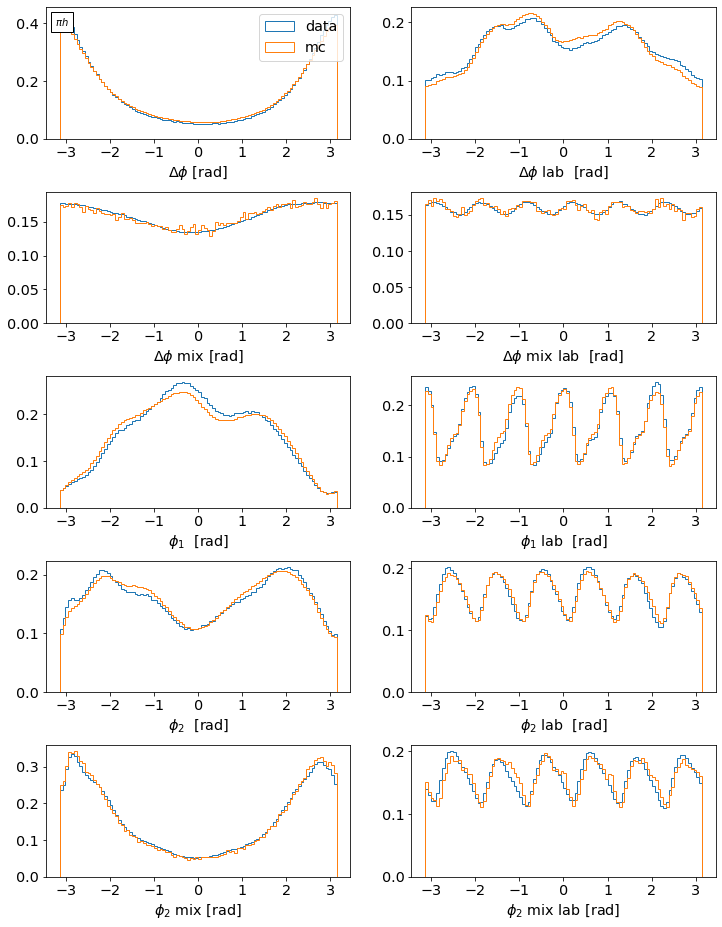

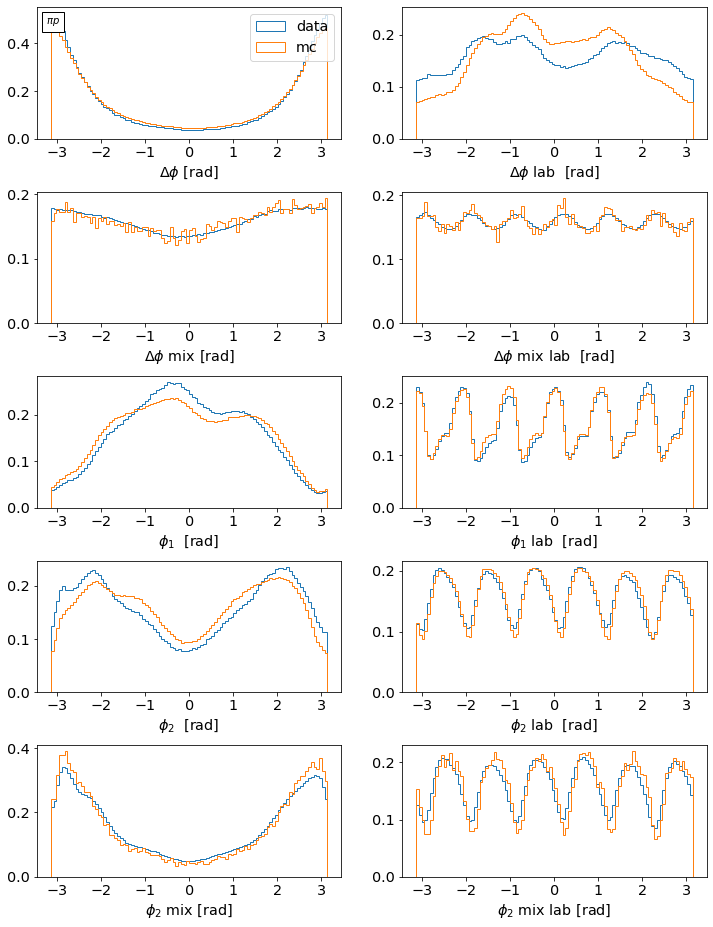

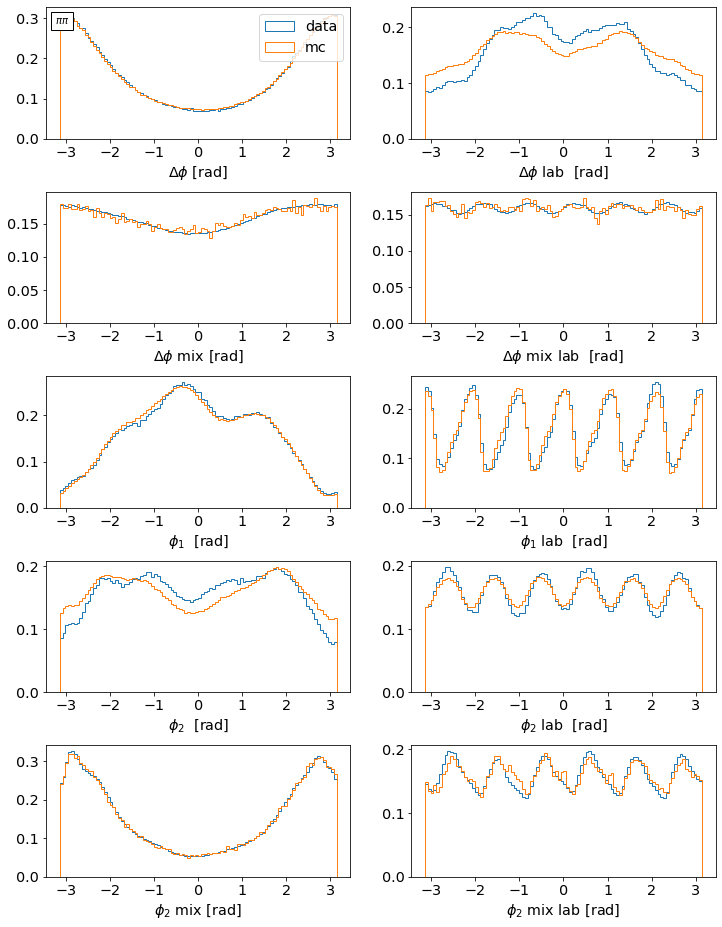

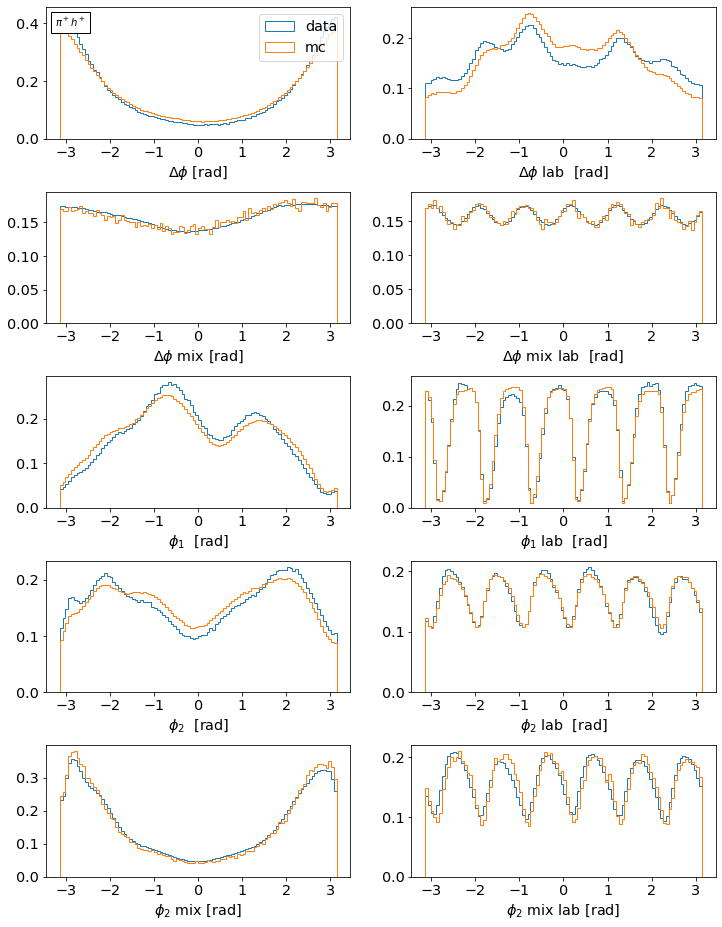

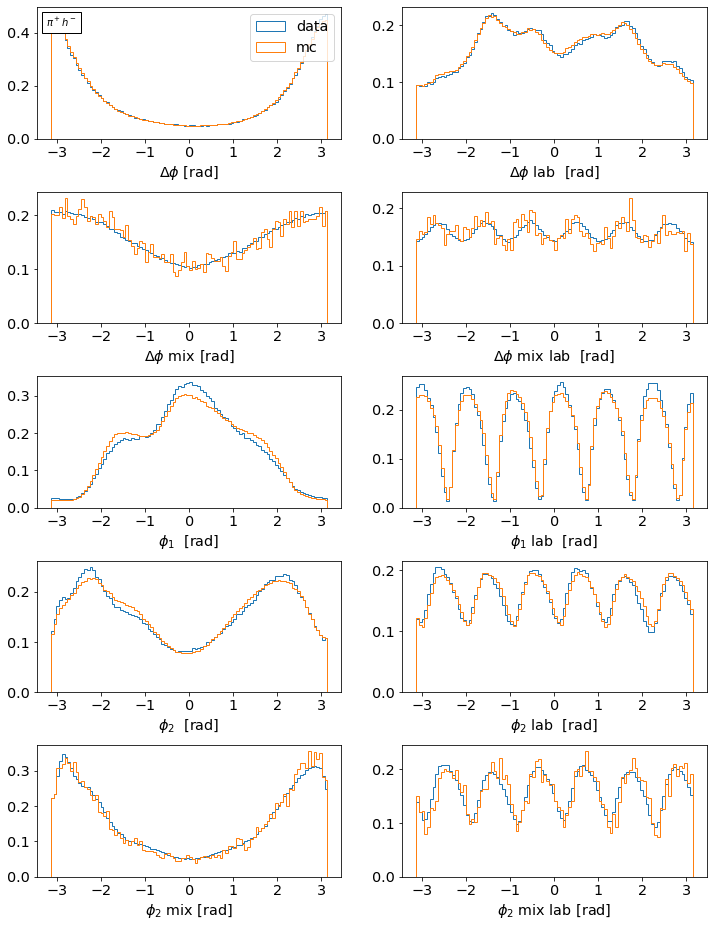

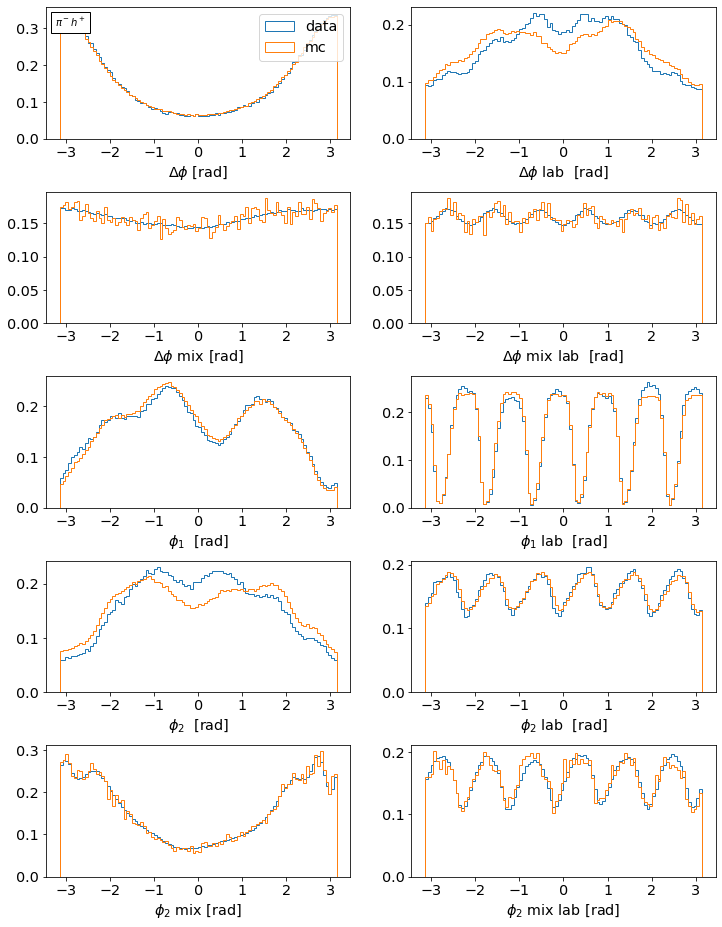

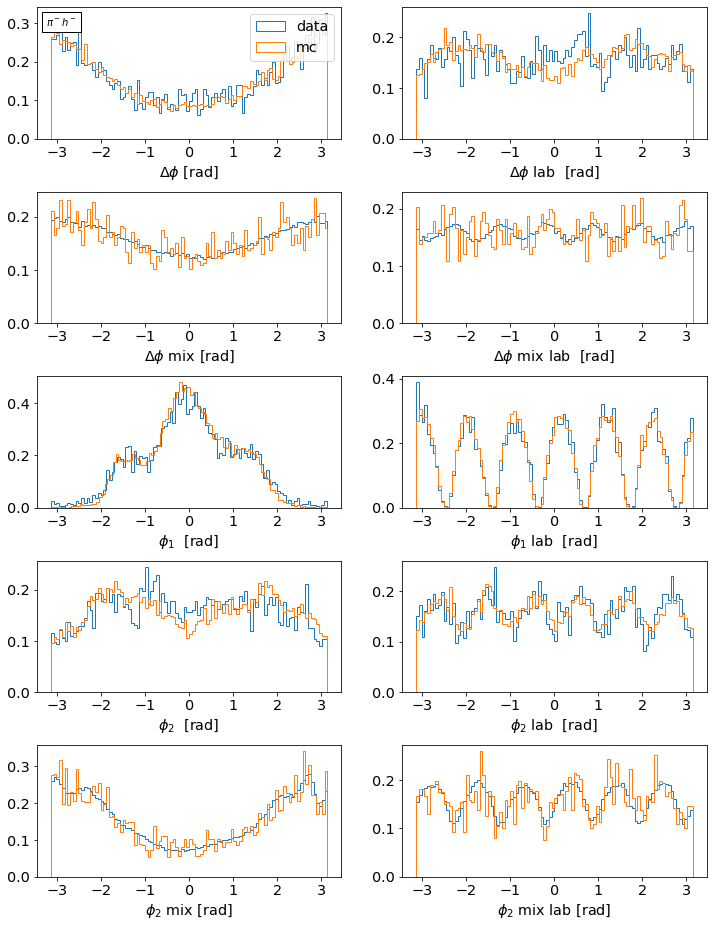

In [170]:
for addQuery, tag, label in [("h2_pid != 0", "_all","$\pi h$"),
                        ("h2_pid == 2212", "_pi_p","$\pi p$"),
                        ("abs(h2_pid) == 211","_pi_pi","$\pi\pi$"),
                        ("h2_pid > 0 and h1_pid > 0", "_++", "$\pi^+h^+$"),
                        ("h2_pid > 0 and h1_pid < 0", "_+-", "$\pi^+h^-$"),
                        ("h2_pid < 0 and h1_pid > 0", "_-+", "$\pi^-h^+$"),
                        ("h2_pid < 0 and h1_pid < 0", "_--", "$\pi^-h^-$")]:
    fig,axs = plt.subplots(5,2, figsize=(12,16))
    #df = data_dihadrons.query('h2_z>0.2 and h2_cm_pt>0.3 and h1_cm_pt>0.3 and diff_rap_cm > 1.5 and '+addQuery)
    #dfm = mixed.query('h2_z>0.2 and h2_cm_pt>0.3 and h1_cm_pt>0.3 and diff_rap_cm> 1.5 and '+addQuery)
    #axs[0][0].add_artist(AnchoredText(label + "\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_1>0.5$\n$\\Delta y>1.5$\n$z_2>0.2$",loc='upper left'))
    axs[0][0].add_artist(AnchoredText(label + "",loc='upper left'))
    for df, dfm in (data_dihadrons.query(addQuery), mixed.query(addQuery)),(mc_dihadrons.query(addQuery), mc_mixed.query(addQuery)):
        axs[0][0].hist(df.diff_phi_cm,bins=100,histtype='step',density='true')
        axs[0][0].set_xlabel("$\Delta\phi$ [rad]")


        axs[1][0].hist(dfm.diff_phi_cm,bins=100,histtype='step',density='true')
        axs[1][0].set_xlabel("$\Delta\phi$ mix [rad]")
        axs[2][0].hist(df.h1_cm_ph,bins=100,histtype='step',density='true')
        axs[2][0].set_xlabel("$\phi_1$  [rad]")
        axs[3][0].hist(df.h2_cm_ph,bins=100,histtype='step',density='true')
        axs[3][0].set_xlabel("$\phi_2$  [rad]")
        axs[4][0].hist(dfm.eval('h2_cm_ph'),bins=100,histtype='step',density='true')
        axs[4][0].set_xlabel("$\phi_2$ mix [rad]")


        axs[0][1].hist(df.h1_ph-df.h2_ph+2*np.pi*(df.h1_ph-df.h2_ph<-np.pi)-2*np.pi*(df.h1_ph-df.h2_ph>np.pi),bins=100,histtype='step',density='true')
        axs[0][1].set_xlabel("$\Delta\phi$ lab  [rad]")
        axs[1][1].hist(dfm.h1_ph-dfm.h2_ph+2*np.pi*(dfm.h1_ph-dfm.h2_ph<-np.pi)-2*np.pi*(dfm.h1_ph-dfm.h2_ph>np.pi),bins=100,histtype='step',density='true')
        axs[1][1].set_xlabel("$\Delta\phi$ mix lab  [rad]")

        axs[2][1].hist(df.h1_ph,bins=100,histtype='step',density='true')
        axs[2][1].set_xlabel("$\phi_1$ lab  [rad]")
        axs[3][1].hist(df.h2_ph,bins=100,histtype='step',density='true')
        axs[3][1].set_xlabel("$\phi_2$ lab  [rad]")
        axs[4][1].hist(dfm.eval('h2_ph'),bins=100,histtype='step',density='true')
        axs[4][1].set_xlabel("$\phi_2$ mix lab [rad]")
    axs[0][0].legend(labels='data mc'.split())
    fig.subplots_adjust(hspace=0.4)
    plt.savefig("../images/mixing_phi"+tag+".pdf")

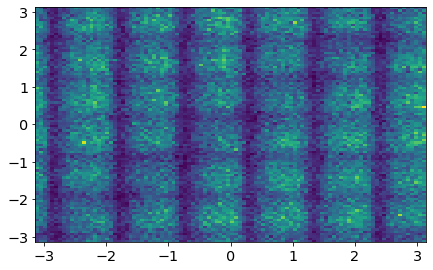

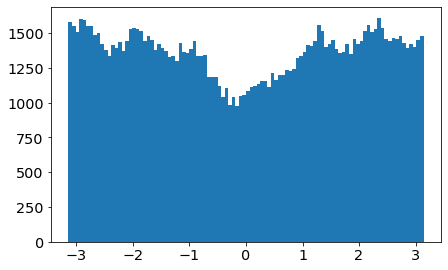

In [107]:
df = mixed.query('h2_z>0.2 and h2_cm_pt>0.3 and h1_cm_pt>0.3 and diff_rap_cm > 1.5')
df = mixed.query('h2_cm_pt>0.2')
plt.hist2d(df.h1_ph,df.h2_ph,bins=100)
plt.show()

def angle(a):
    return a+2*np.pi*(a<-np.pi)-2*np.pi*(a>np.pi)
plt.hist(angle(df.h1_ph-df.h2_ph),bins=100)
plt.show()

In [ ]:
for df0 in data_dihadrons, mc_dihadrons:
    df.histogram

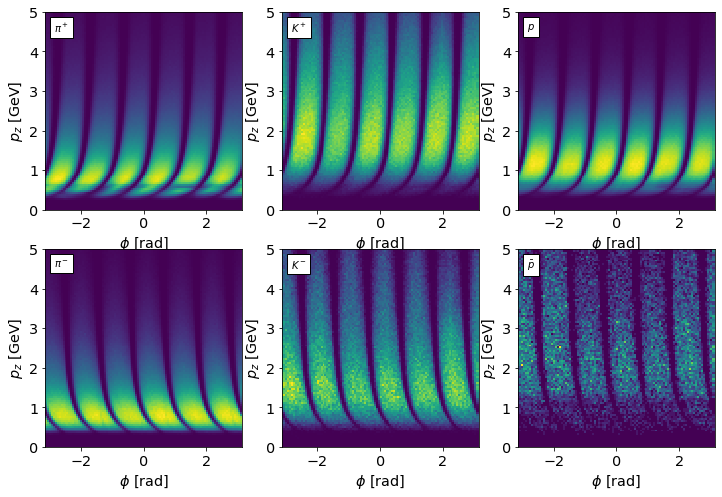

In [65]:
fig,axs = plt.subplots(2,3, figsize=(12, 8))
for j,(pid,name) in enumerate(((211,"$\\pi^+$"), (-211,"$\\pi^-$"), (321,"$K^+$"),
                                (-321,"$K^-$"),(2212,"$p$"),(-2212,"$\\bar p$"))):
    df = data_hadrons.query("h_pid == " + str(pid))
    plt.sca(axs[j%2][j//2])
    plt.hist2d(df.h_ph, df.h_pz, bins=100, range=((-np.pi, np.pi),(0,5)))
    plt.gca().add_artist(AnchoredText(name,loc='upper left'))
    plt.gca().set_xlabel("$\phi$ [rad]")
    plt.gca().set_ylabel("$p_z$ [GeV]")
plt.savefig("../images/phi_vs_pz.pdf")

In [ ]:
#use pseudorapidity since rapidity isn't in the mc tuples yet
#mc_dihadrons['h1_cm_rap']= mc_dihadrons['h1_cm_eta']
#mc_dihadrons['h2_cm_rap']= mc_dihadrons['h2_cm_eta']
#mix(mc_dihadrons)

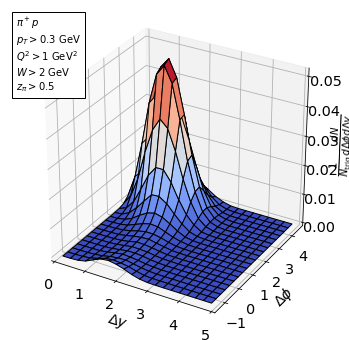

In [79]:

def offset(a):
    return a+2*np.pi*(a<-np.pi/2)-2*np.pi*(a>3*np.pi/2)

def dphi_deta_plot(df,df_mixed,df_trig,deta_range=(-2,6),bins=20,fig=None):
    dphi_range = (-np.pi/2,3*np.pi/2)
    x = df.diff_rap_cm
    y = offset(df.diff_phi_cm)
    if fig == None:
        fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[deta_range, dphi_range])
    
    denom = len(df_trig)*2*np.pi/bins*(deta_range[1]-deta_range[0])/bins
    hist = np.divide(hist, denom)
    xpos, ypos = np.meshgrid(np.add(xedges[:-1],xedges[1:])/2, np.add(yedges[:-1],yedges[1:])/2)
    zpos = 0

    surf = ax.plot_surface(xpos, ypos, hist.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax.set_xlabel("$\\Delta y$")
    ax.set_ylabel("$\\Delta\\phi$")
    ax.set_zlabel("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi d\\Delta y}$",rotation=-90)
    ax.set_xlim(*deta_range)
    ax.set_ylim(*dphi_range)
    return fig,ax
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
df_trig = data_triggers.query("h_cm_pt>0.3")
fig,ax = dphi_deta_plot(df,df_trig,
              deta_range=(0,5))
plt.gca().add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.savefig("../images/dphi_vs_deta_pi_p.pdf",bbox_inches='tight')
plt.show()

In [282]:

def offset(a):
    return a+2*np.pi*(a<-np.pi/2)-2*np.pi*(a>3*np.pi/2)
def dphi_deta_plot_3(df,df_mixed,df_trig,deta_range=(-1.5,2.5),bins=20,fig=None):
    dphi_range = (-np.pi/2,3*np.pi/2)
    if fig == None:
        fig = plt.figure(figsize=(18,6))
    ax1 = fig.add_subplot(131, projection='3d')
    
    denom = len(df_trig)*2*np.pi/bins*(deta_range[1]-deta_range[0])/bins
    hist1, xedges, yedges = np.histogram2d(df.diff_rap_cm, offset(df.diff_phi_cm), bins=bins, range=[deta_range, dphi_range])
    hist1 = np.divide(hist1, denom)
    print(xedges)
    hist2, xedges, yedges = np.histogram2d(df_mixed.diff_rap_cm, offset(df_mixed.diff_phi_cm), bins=bins, range=[deta_range, dphi_range])
    
    for i in range(bins):
        if xedges[i+1]>0:
            break
    for j in range(bins):
        if yedges[j+1]>0:
            break;
    denom = hist2[i][j]
    
    hist2 = np.divide(hist2,denom)
    
    
    hist3 = np.divide(hist1,hist2)
    
    xpos, ypos = np.meshgrid(np.add(xedges[:-1],xedges[1:])/2, np.add(yedges[:-1],yedges[1:])/2)
    zpos = 0

    surf = ax1.plot_surface(xpos, ypos, hist1.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax1.set_xlabel("$\\Delta y$")
    ax1.set_ylabel("$\\Delta\\phi$")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_title("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi d\\Delta y}$",rotation=0)
    ax1.set_xlim(*deta_range)
    ax1.set_ylim(*dphi_range)
    
    
    ax2 = fig.add_subplot(132, projection='3d')
    surf = ax2.plot_surface(xpos, ypos, hist2.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax2.set_xlabel("$\\Delta y$")
    ax2.set_ylabel("$\\Delta\\phi$")
    ax2.zaxis.set_rotate_label(False)
    ax2.set_title("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi d\\Delta y}$ mix",rotation=0)
    ax2.set_xlim(*deta_range)
    ax2.set_ylim(*dphi_range)
    
    
    
    ax3 = fig.add_subplot(133, projection='3d')
    surf = ax3.plot_surface(xpos, ypos, hist3.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax3.set_xlabel("$\\Delta y$")
    ax3.set_ylabel("$\\Delta\\phi$")
    ax3.zaxis.set_rotate_label(False)
    ax3.set_title("$C(\\Delta\\phi,\\Delta y)$",rotation=0)
    ax3.set_xlim(*deta_range)
    ax3.set_ylim(*dphi_range)
    
    
    return fig,[ax1,ax2,ax3]

In [306]:



def offset(a):
    return a+2*np.pi*(a<-np.pi/2)-2*np.pi*(a>=3*np.pi/2)
def dphi_deta_plot_3_proj(df,df_mixed,df_trig,deta_range=(-1.5,2.5),bins=20,
                          fig=None,projyrange=(1.5,2.5),bins1d=50,minbincontentindenom=3, normalizeMixedAt00=True):
    dphi_range = (-np.pi/2,3*np.pi/2)
    if fig == None:
        fig = plt.figure(figsize=(18,12))
    ax1 = fig.add_subplot(231, projection='3d')
    ax1.view_init(azim=-135)
    
    denom = len(df_trig)*2*np.pi/bins*(deta_range[1]-deta_range[0])/bins
    hist1, xedges, yedges = np.histogram2d(df.diff_rap_cm, offset(df.diff_phi_cm), bins=bins, range=[deta_range, dphi_range])
    hist1 = np.divide(hist1, denom)
    print(xedges)
    hist2, xedges, yedges = np.histogram2d(df_mixed.diff_rap_cm, offset(df_mixed.diff_phi_cm), bins=bins, range=[deta_range, dphi_range])
    for i in range(bins):
        if xedges[i+1]>0:
            break
    for j in range(bins):
        if yedges[j+1]>0:
            break;
            
    radius = .3
    if normalizeMixedAt00:
        M00 = len(df_mixed.query('sqrt(diff_rap_cm**2+diff_phi_cm**2)<%s'%radius))/(np.pi*radius**2)
        #print("M(0,0) = ", M00)
        hist2 = np.divide(hist2,M00*(xedges[1]-xedges[0])*(yedges[1]-yedges[0]))
    else :
        hist2 = np.divide(hist2,len(df_mixed)*(xedges[1]-xedges[0])*(yedges[1]-yedges[0]))
    #radius = .1
    #M00 = len(df_mixed.query('sqrt(diff_rap_cm**2+diff_phi_cm**2)<%s'%radius))/(np.pi*radius**2)
    #print("M(0,0) = ", M00)
    #radius = .5
    #M00 = len(df_mixed.query('sqrt(diff_rap_cm**2+diff_phi_cm**2)<%s'%radius))/(np.pi*radius**2)
    #print("M(0,0) = ", M00)
    
    
    
    hist3 = np.divide(hist1,np.add(hist2,0.01))
    hist3 *= np.greater(hist2*M00*(xedges[1]-xedges[0])*(yedges[1]-yedges[0]),minbincontentindenom)
    
    
    
    xpos, ypos = np.meshgrid(np.add(xedges[:-1],xedges[1:])/2, np.add(yedges[:-1],yedges[1:])/2)
    zpos = 0

    surf = ax1.plot_surface(xpos, ypos, hist1.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax1.set_xlabel("$\\Delta y$")
    ax1.set_ylabel("$\\Delta\\phi$ [rad]")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_title("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi d\\Delta y}$",rotation=0)
    ax1.set_xlim(*deta_range)
    ax1.set_ylim(*dphi_range)
    
    
    ax2 = fig.add_subplot(232, projection='3d')
    ax2.view_init(azim=-135)
    surf = ax2.plot_surface(xpos, ypos, hist2.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax2.set_xlabel("$\\Delta y$")
    ax2.set_ylabel("$\\Delta\\phi$ [rad]")
    ax2.zaxis.set_rotate_label(False)
    ax2.set_title("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi d\\Delta y}$ mix",rotation=0)
    ax2.set_xlim(*deta_range)
    ax2.set_ylim(*dphi_range)
    
    
    
    ax3 = fig.add_subplot(233, projection='3d')
    ax3.view_init(azim=-135)
    surf = ax3.plot_surface(xpos, ypos, hist3.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax3.set_xlabel("$\\Delta y$")
    ax3.set_ylabel("$\\Delta\\phi$ [rad]")
    ax3.zaxis.set_rotate_label(False)
    ax3.set_title("$C(\\Delta\\phi,\\Delta y)$",rotation=0)
    ax3.set_xlim(*deta_range)
    ax3.set_ylim(*dphi_range)
    
    
    bins = bins1d
    #now for 1d projections:
    ax4 = fig.add_subplot(234)
    
    denom = len(df_trig)*2*np.pi/bins
    y, x = np.histogram(offset(df.query("diff_rap_cm > %s and diff_rap_cm < %s" %projyrange).diff_phi_cm), bins=bins, range=(-np.pi/2,3*np.pi/2))
    x = np.add(x[1:],x[:-1])/2
    dy = np.sqrt(y)
    y=np.divide(y,denom)
    dy=np.divide(dy,denom)
    
    def plot1d(x,y,dy,ax,n=5):
        ax.errorbar(x,y,dy,marker='o',color='k',linestyle='')
        ax.axhline(0,color='0.7',linestyle=':')
        #a = [2*sum(y*np.sin(i*x))/len(x) for i in range(0,n+1)]
        #remove sin term
        #a = [0 for i in range(0,n+1)]
        b = [2*sum(y*np.cos(i*x))/len(x) for i in range(0,n+1)]
        b[0]/=2
        s = 0
        for i in range(0,n+1):
            s = b[i]*np.cos(i*x)+s
        ax.plot(x,s,linestyle='-',color='k',label='all')
        for i in range(1,n+1):
            ax.plot(x,b[i]*np.cos(i*x)+b[0]*(i!=0),linestyle='--', label="n=%s"%i)
        ax.set_xlim(-np.pi/2,np.pi*3/2)
    plot1d(x,y,dy,ax4)
    
    
    mixed_highy = df_mixed.query("diff_rap_cm > %s and diff_rap_cm < %s" %projyrange)
    if(normalizeMixedAt00):
        denom = M00*2*np.pi/bins1d
    else :
        denom = len(mixed_highy)*2*np.pi/bins1d
    ym, _ = np.histogram(offset(mixed_highy.diff_phi_cm), bins=bins, range=(-np.pi/2,3*np.pi/2))
    dym = np.sqrt(ym)
    ym=np.divide(ym,denom)
    dym=np.divide(dym,denom)
    
    ax5 = fig.add_subplot(235)
    plot1d(x,ym,dym,ax5)
    ax3.set_ylabel("$\\Delta\\phi$ [rad]")
    
    ax6 = fig.add_subplot(236)
    dyc = y/ym*np.hypot(dy/y, dym/ym)
    yc= y/ym
    plot1d(x,yc,dyc,ax6)
    
    return fig,[ax1,ax2,ax3,ax4, ax5, ax6]

[-0.5  -0.35 -0.2  -0.05  0.1   0.25  0.4   0.55  0.7   0.85  1.    1.15
  1.3   1.45  1.6   1.75  1.9   2.05  2.2   2.35  2.5 ]


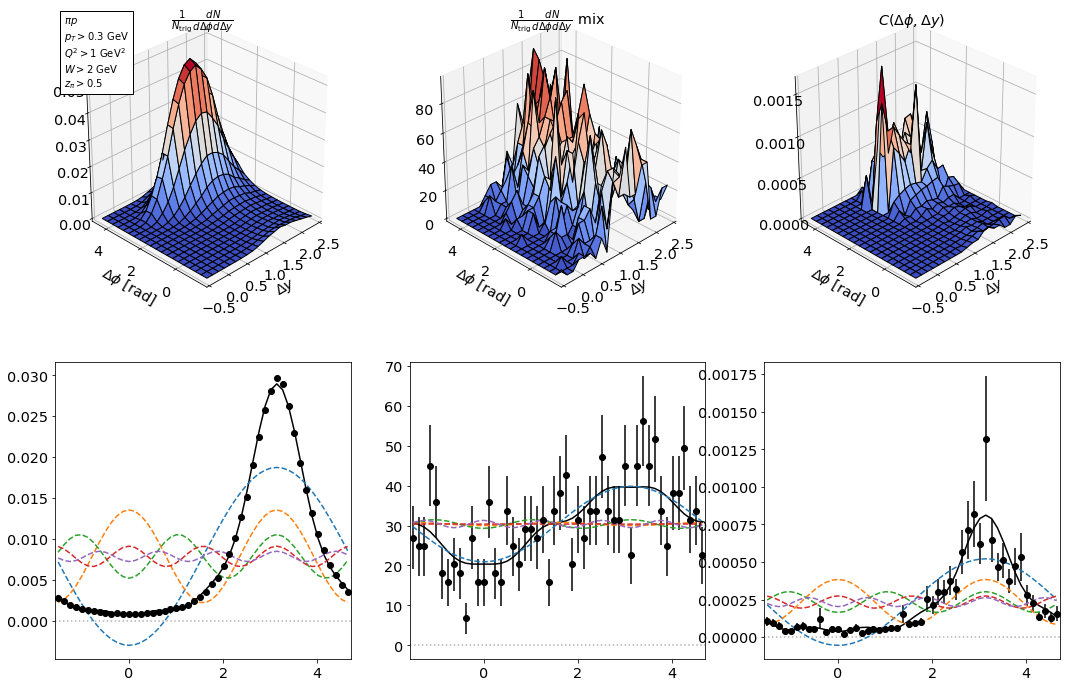

[-0.5  -0.35 -0.2  -0.05  0.1   0.25  0.4   0.55  0.7   0.85  1.    1.15
  1.3   1.45  1.6   1.75  1.9   2.05  2.2   2.35  2.5 ]


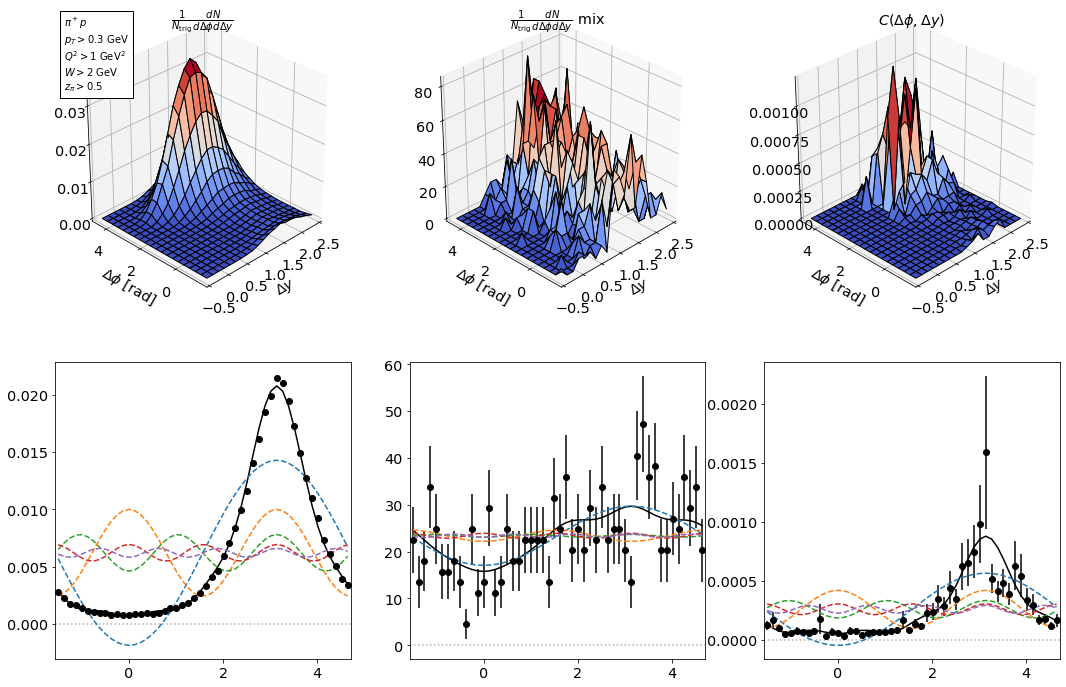

[-0.5  -0.35 -0.2  -0.05  0.1   0.25  0.4   0.55  0.7   0.85  1.    1.15
  1.3   1.45  1.6   1.75  1.9   2.05  2.2   2.35  2.5 ]


<ipython-input-306-87305b9d398a>:27: RuntimeWarning: divide by zero encountered in true_divide
  hist2 = np.divide(hist2,M00*(xedges[1]-xedges[0])*(yedges[1]-yedges[0]))
<ipython-input-306-87305b9d398a>:27: RuntimeWarning: invalid value encountered in true_divide
  hist2 = np.divide(hist2,M00*(xedges[1]-xedges[0])*(yedges[1]-yedges[0]))
<ipython-input-306-87305b9d398a>:40: RuntimeWarning: invalid value encountered in multiply
  hist3 *= np.greater(hist2*M00*(xedges[1]-xedges[0])*(yedges[1]-yedges[0]),minbincontentindenom)
<ipython-input-306-87305b9d398a>:58: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax2.plot_surface(xpos, ypos, hist2.transpose(), cmap=cm.coolwarm,edgecolor='k')
<ipython-input-306-87305b9d398a>:70: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  surf = ax3.plot_surface(xpos, ypos, hist3.transpose(), cmap=cm.coolwarm,edgecolor='k')
<ipython-input-306-87305b9d398a>:115: RuntimeWarning: divide by zero

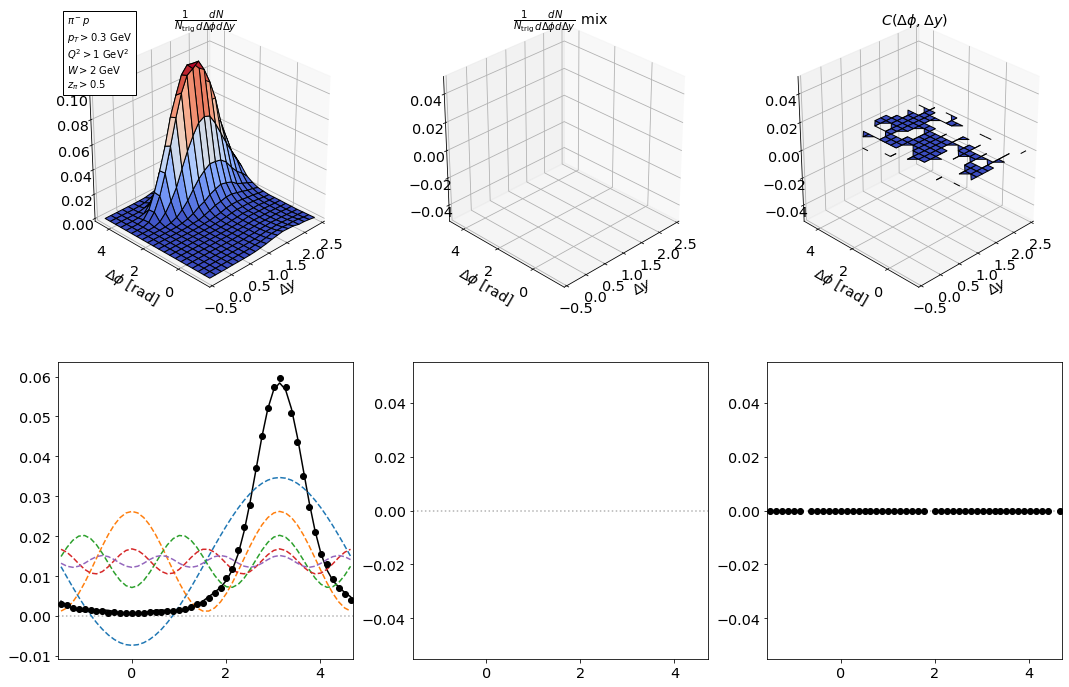

[-0.5  -0.35 -0.2  -0.05  0.1   0.25  0.4   0.55  0.7   0.85  1.    1.15
  1.3   1.45  1.6   1.75  1.9   2.05  2.2   2.35  2.5 ]


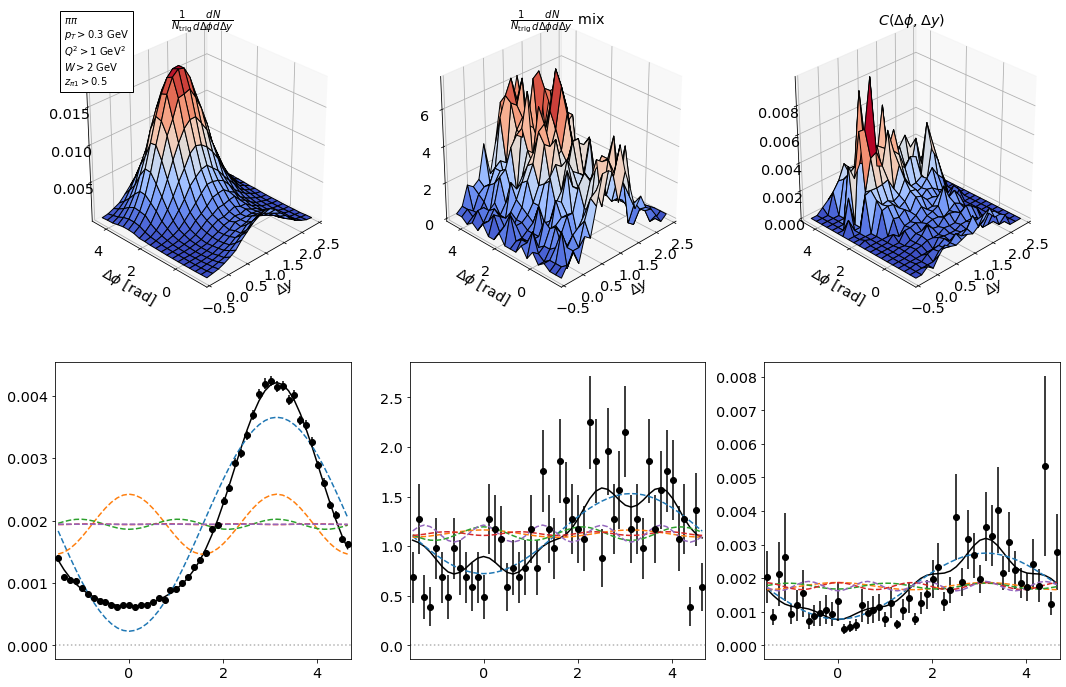

In [337]:
#pi+- p, 
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and abs(h1_pid) == 211")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and abs(h1_pid) == 211")
df_trig = data_triggers.query("h_cm_pt>0.3 and abs(h_pid) == 211")
fig,axs = dphi_deta_plot_3_proj(df,df_mixed,df_trig,
              deta_range=(-0.5,2.5))
axs[0].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.savefig("../images/dphi_vs_deta_pi_p.pdf",bbox_inches='tight')
plt.show()

#pi+ p
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and h1_pid == 211")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and h1_pid == 211")
df_trig = data_triggers.query("h_cm_pt>0.3 and h_pid == 211")
fig,axs = dphi_deta_plot_3_proj(df,df_mixed,df_trig,
              deta_range=(-0.5,2.5))
axs[0].add_artist(AnchoredText("$\pi^+ p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.savefig("../images/dphi_vs_deta_pi+_p.pdf",bbox_inches='tight')
plt.show()


#pi- p
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and h1_pid == -211")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and h1_pid == -211")
df_trig = data_triggers.query("h_cm_pt>0.3 and h_pid == -211")
fig,axs = dphi_deta_plot_3_proj(df,df_mixed,df_trig,
              deta_range=(-0.5,2.5))
axs[0].add_artist(AnchoredText("$\pi^- p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.savefig("../images/dphi_vs_deta_pi-_p.pdf",bbox_inches='tight')
plt.show()


#pi pi (either charge)
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211 and abs(h1_pid) == 211")
df_trig = data_triggers.query("h_cm_pt>0.3 and abs(h_pid) == 211")
fig,axs = dphi_deta_plot_3_proj(df,df_mixed,df_trig,
              deta_range=(-0.5,2.5))
axs[0].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_{\\pi1}>0.5$",loc='upper left'))
plt.savefig("../images/dphi_vs_deta_pi_pi.pdf",bbox_inches='tight')
plt.show()

In [ ]:
def v2_plot(df, df_mixed, )

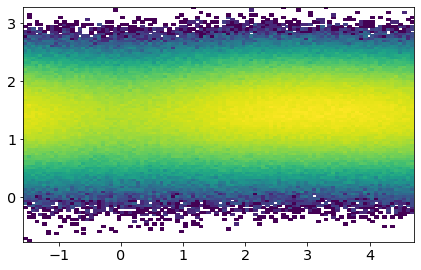

In [245]:
import matplotlib as mpl
df = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and abs(h1_pid) == 211")
plt.hist2d(offset(df.diff_phi_cm),df.diff_rap_cm,norm=mpl.colors.LogNorm(), bins=100)
plt.show()

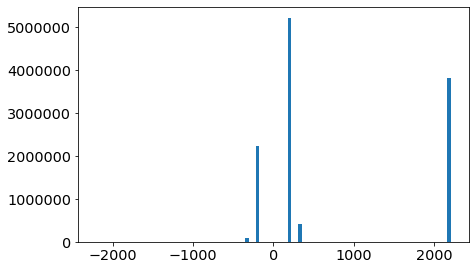

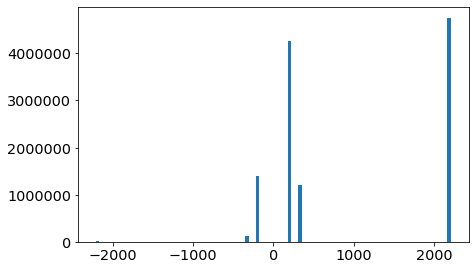

In [189]:
plt.hist(mixed.h2_pid, bins=100)
plt.show()
plt.hist(mixed.h1_pid, bins=100)
plt.show()

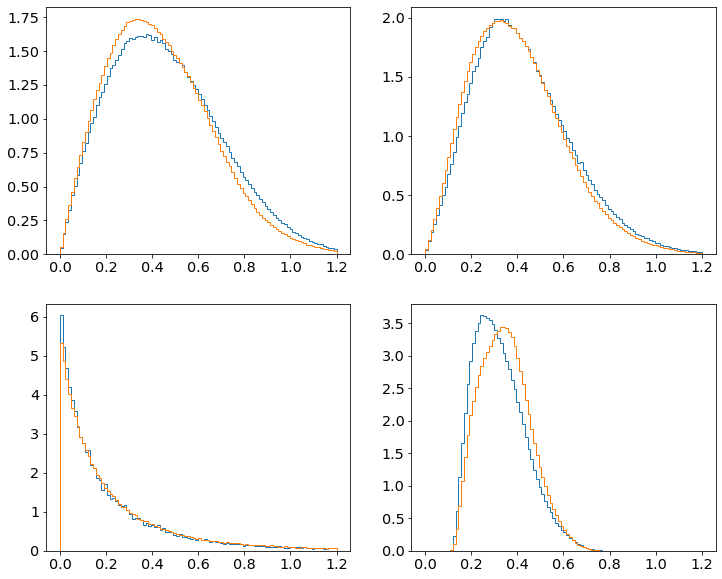

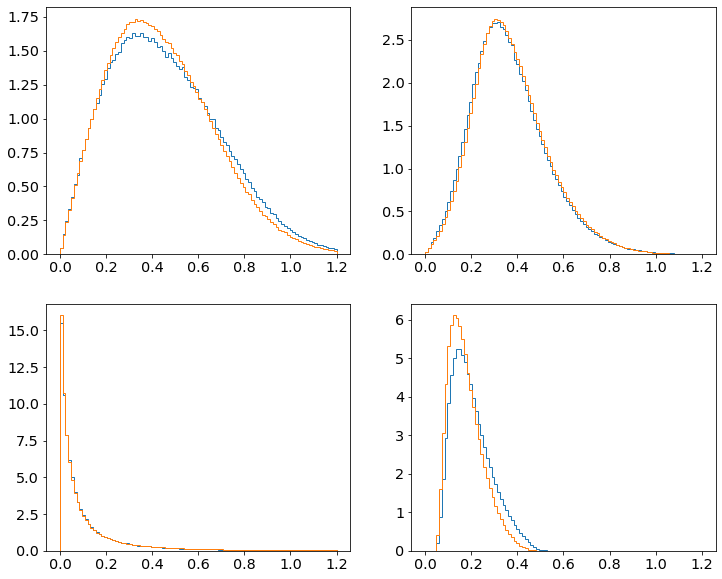

In [95]:

for q in 'h2_pid == 2212', 'abs(h2_pid) == 211':
    fig,axs = plt.subplots(2,2, figsize=(12,10))
    for df in data_dihadrons, mc_dihadrons:
        df = df.query(q)
        axs[0][0].hist(df.h1_cm_pt,density=True,bins=100, histtype='step',range=(0,1.2))
        axs[0][1].hist(df.h2_cm_pt,density=True,bins=100, histtype='step',range=(0,1.2))
        axs[1][0].hist(df.diff_rap_cm-df.diff_eta_cm,density=True,bins=100, histtype='step',range=(0,1.2))
        axs[1][1].hist(df.h2_z,density=True,bins=100, histtype='step',range=(0,1.2))


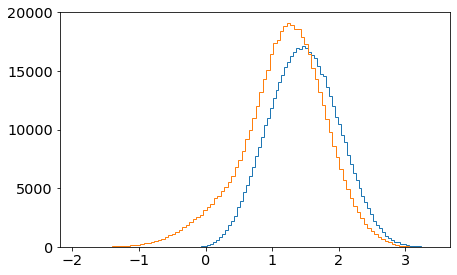

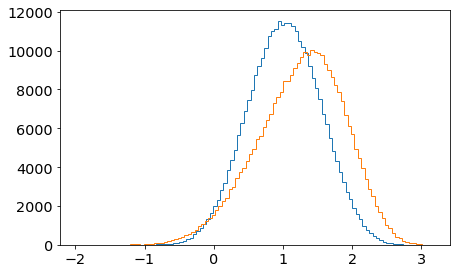

In [79]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
plt.hist(df.diff_rap_cm,bins=100,histtype='step')
plt.hist(df.mix_diff_rap,bins=100,histtype='step')
plt.show()
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")
plt.hist(df.diff_rap_cm,bins=100,histtype='step')
plt.hist(df.mix_diff_rap,bins=100,histtype='step')
plt.show()

In [136]:
import misc_util

def azimuthalPlot(df,df_mixed, ntrig_real, ntrig_mixed, n=4,bins = 50, includeResiduals=False,includeLegend=True,style='normal',
                 normalize_properly=True,show='corr',frame='cm',truth=False):
    if(includeResiduals):
        fig,axs = plt.subplots(2,1, figsize=(7,7), gridspec_kw={'height_ratios': [3, 1]}, 
                              sharex='all')
        plt.sca(axs[0])
    x,y,dy = [],[],[]
    
    if frame == 'cm':
        diff_phi_shift = offset(df.diff_phi_cm)
        mix_diff_phi_shift = offset(df_mixed.diff_phi_cm)
    elif frame== 'lab':
        if not truth:
            diff_phi_shift = offset(df.diff_phi_lab)
            mix_diff_phi_shift = offset(df_mixed.diff_phi_lab)
        else:
            diff_phi_shift = df.diff_phi_shift_lab_truth
            mix_diff_phi_shift = df.query('mix_found > 0').mix_diff_phi_shift_lab_truth
    
    denom = ntrig_real*2*np.pi/bins
    y, x = np.histogram(diff_phi_shift, bins=bins, range=(-np.pi/2,3*np.pi/2))
    x = np.add(x[1:],x[:-1])/2
    dy = np.sqrt(y)
    y=np.divide(y,denom)
    dy=np.divide(dy,denom)
    
    denom = ntrig_mixed*2*np.pi/bins
    ym, _ = np.histogram(mix_diff_phi_shift, bins=bins, range=(-np.pi/2,3*np.pi/2))
    dym = np.sqrt(ym)
    ym=np.divide(ym,denom)
    dym=np.divide(dym,denom)
    if show == 'corr':
        dy = y/ym*np.hypot(dy/y, dym/ym)
        y= y/ym
    elif show == 'mix':
        y=ym
        dy = dym
    
    
    if style== 'normal':
        plt.errorbar(x,y,dy,marker='o',color='k',linestyle='')
        plt.axhline(0,color='0.7',linestyle=':')
        #a = [2*sum(y*np.sin(i*x))/len(x) for i in range(0,n+1)]
        #remove sin term
        #a = [0 for i in range(0,n+1)]
        b = [2*sum(y*np.cos(i*x))/len(x) for i in range(0,n+1)]
        b[0]/=2
        s = 0
        for i in range(0,n+1):
            s = b[i]*np.cos(i*x)+s
        plt.plot(x,s,linestyle='-',color='k',label='all')
        for i in range(1,n+1):
            plt.plot(x,b[i]*np.cos(i*x)+b[0]*(i!=0),linestyle='--', label="n=%s"%i)
        plt.gca().set_xlim(-np.pi/2,np.pi*3/2)
        if show == 'same':
            plt.gca().set_ylabel("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi}$",rotation=0,fontsize=20,labelpad=25)
        elif show == 'corr' :
            plt.gca().set_ylabel("$C(\\Delta\\phi)$",rotation=0,fontsize=20,labelpad=25)
        elif show == 'mix' :
            plt.gca().set_ylabel("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN^{\\mathrm{mix}}}{d\\Delta\\phi}$",rotation=0,fontsize=20,labelpad=25)
                
    elif style=='bar':
        plt.gca().bar(x,y,x[1]-x[0],alpha=0.3,color='tab:pink')
    if not includeResiduals:
        plt.gca().set_xlabel("$\\Delta\\phi$ [rad]")
    if includeLegend:
        legend = plt.gca().legend(title="Fourier fit",loc='upper left')
        plt.setp(legend.get_title(),fontsize=12)
    if includeResiduals:
        plt.sca(axs[1])
        plt.errorbar(x,(y-s)/dy,1,marker='o',color='k',linestyle='')
        plt.gca().set_xlabel("$\\Delta\\phi$ [rad]")
        axs[1].set_ylabel('normed residual')
        #lims = axs[0].get_ylim()
        #axs[1].set_ylim(-(lims[1]-lims[0])/6,(lims[1]-lims[0])/6)
        plt.sca(axs[0])
        plt.subplots_adjust(hspace=0)

In [153]:
def azimuthalPlot_3(df_real,df_mixed,ntrig_real, ntrig_mixed,n=4,bins = 50, includeResiduals=False,includeLegend=True,style='normal',
                 normalize_properly=True,frame='cm',truth=False):
    fig,axs = plt.subplots(1,3, figsize=(18,6))
    plt.sca(axs[0])
    azimuthalPlot(df_real,df_mixed,ntrig_real, ntrig_mixed,n,bins,includeLegend=True,show='same',frame=frame,truth=truth)
    plt.sca(axs[1])
    axs[0].get_shared_y_axes().join(axs[0], axs[1])
    azimuthalPlot(df_real,df_mixed,ntrig_real, ntrig_mixed, n,bins,includeLegend=False,show='mix',frame=frame,truth=truth)
    plt.sca(axs[2])
    azimuthalPlot(df_real,df_mixed,ntrig_real, ntrig_mixed, n,bins,includeLegend=False,show='corr',frame=frame,truth=truth)
    fig.subplots_adjust(wspace=0.4)
    return fig, axs

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0., 315514., 301028., 286118., 274175., 259918., 248240.,
        236777., 226403., 217260., 206886., 197862., 190165., 182365.,
        175013., 167416., 161653., 155499., 149685., 143933., 139040.,
        134014., 129623., 125141., 120587., 116746., 113333., 109739.,
        106323., 102707.,  99321.,  95848.,  92367.,  89319.,  86488.,
         83890.,  81859.,  78960.,  76757.,  74390.,  72088.,  70605.,
         67606.,  65856.,  63056.,  61405.,  60235.,  59230.,  55958.,
      

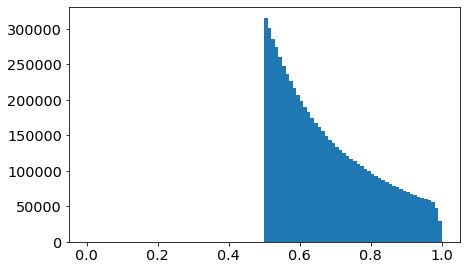

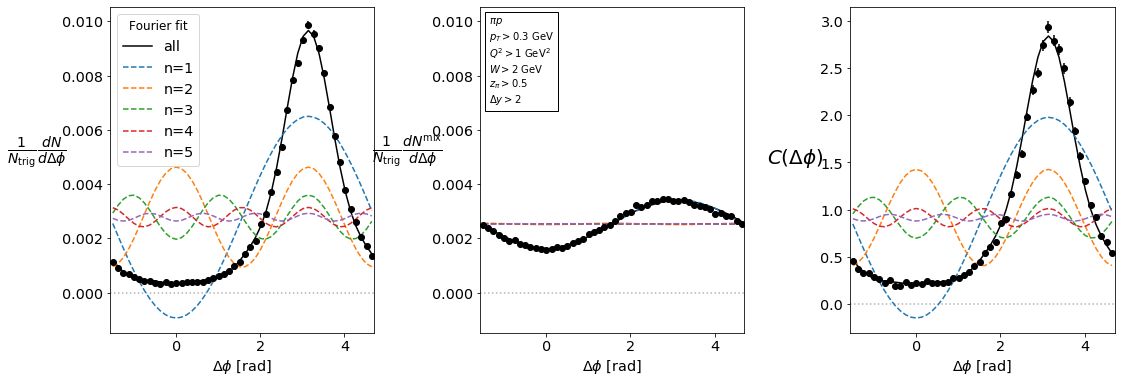

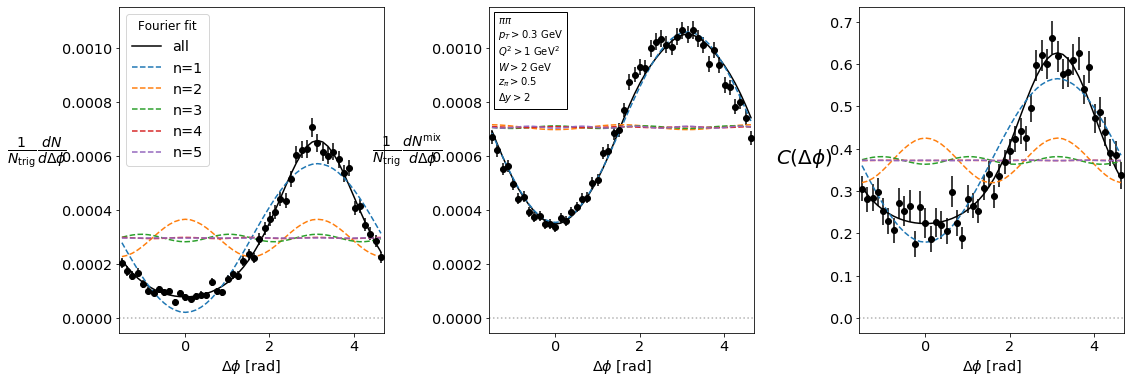

In [172]:
#cm frame

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3 and diff_rap_cm>2"\
                         + "and h2_pid == 2212")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3 and diff_rap_cm>2"\
                         + "and h2_pid == 2212")
ntrig_mixed = len(mixed.query("h1_cm_pt>0.3"))
ntrig_real = len(data_triggers.query("h_cm_pt>0.3"))

fig,axs = azimuthalPlot_3(df,df_mixed, ntrig_real, ntrig_mixed,n=5)
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.savefig("../images/corr_1d_pi_p.pdf")
plt.show()

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3 and diff_rap_cm>2"\
                         + "and abs(h2_pid) == 211")
df_mixed = mixed.query("h1_cm_pt>0.3 and h2_cm_pt>0.3 and diff_rap_cm>2"\
                         + "and abs(h2_pid) == 211")

fig,axs = azimuthalPlot_3(df,df_mixed,ntrig_real,ntrig_mixed,n=5)
axs[1].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.savefig("../images/corr_1d_pi_pi.pdf")
plt.show()

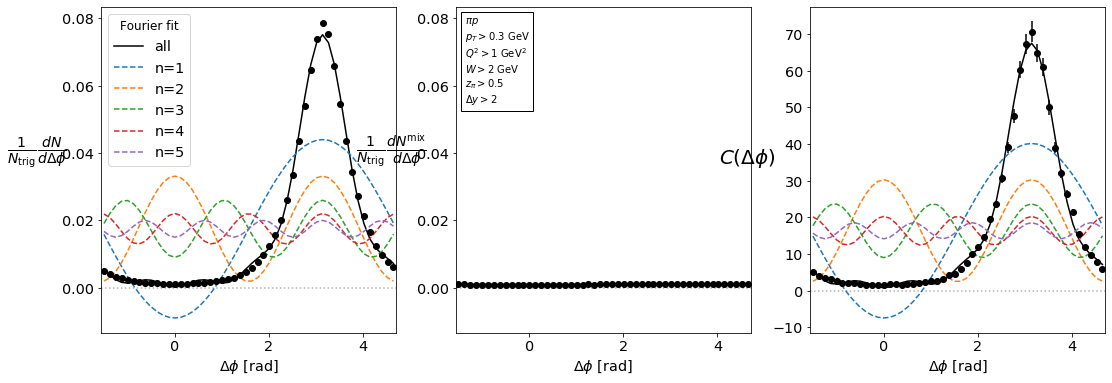

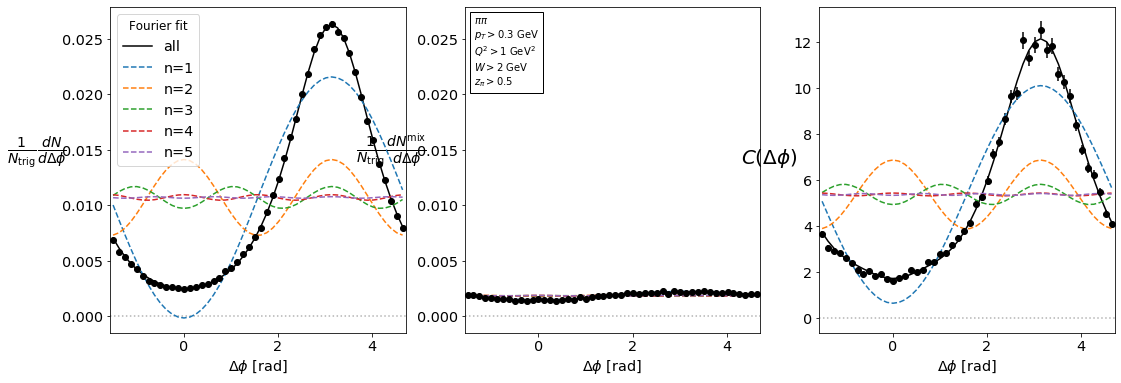

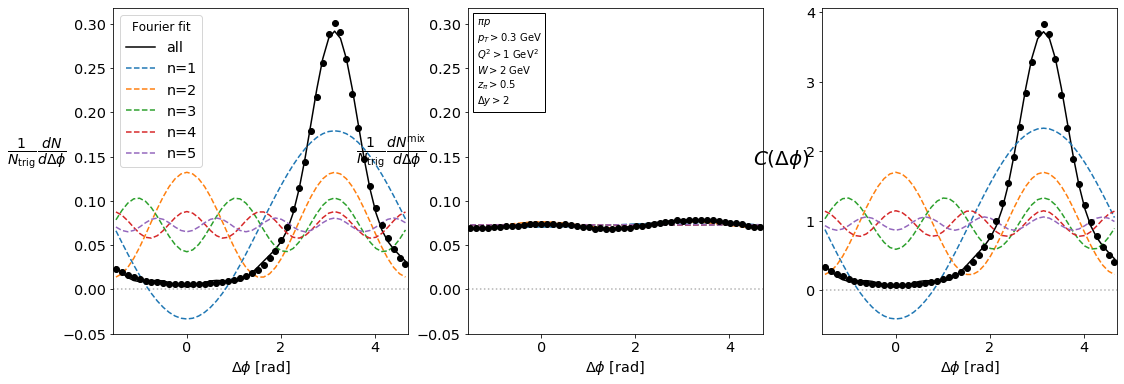

In [27]:
#cm frame  (MC)
df = mc_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
fig,axs = azimuthalPlot_3(df,df_trig,n=5)
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.show()


MC RECON


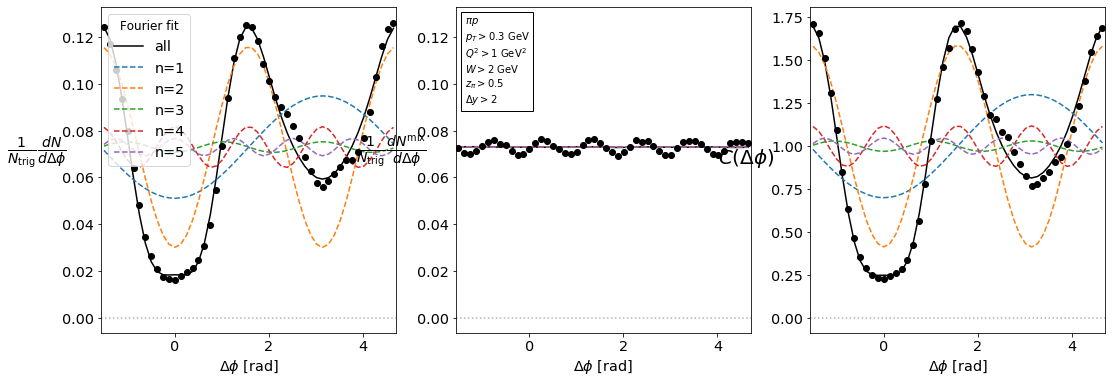

MC TRUTH


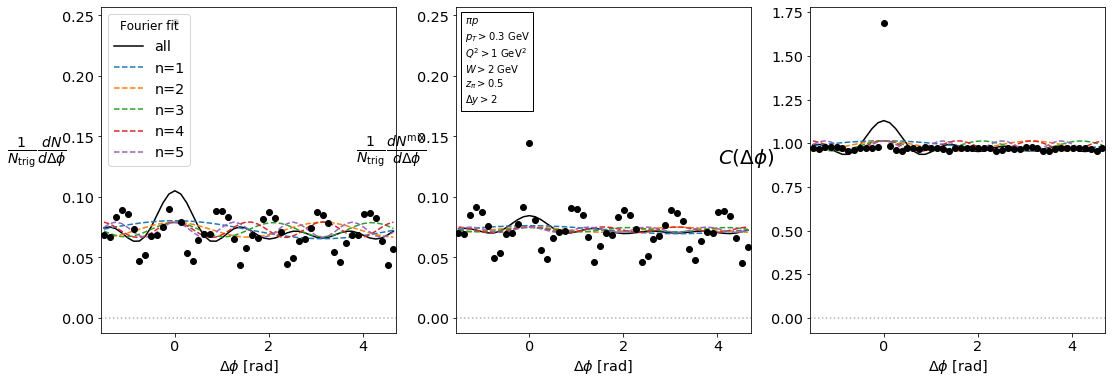

In [28]:
#lab frame MC
print("MC RECON")
df = mc_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab')
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.show()
#lab frame MC TRUTH

print("MC TRUTH")
df = mc_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab',truth=True)
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.show()

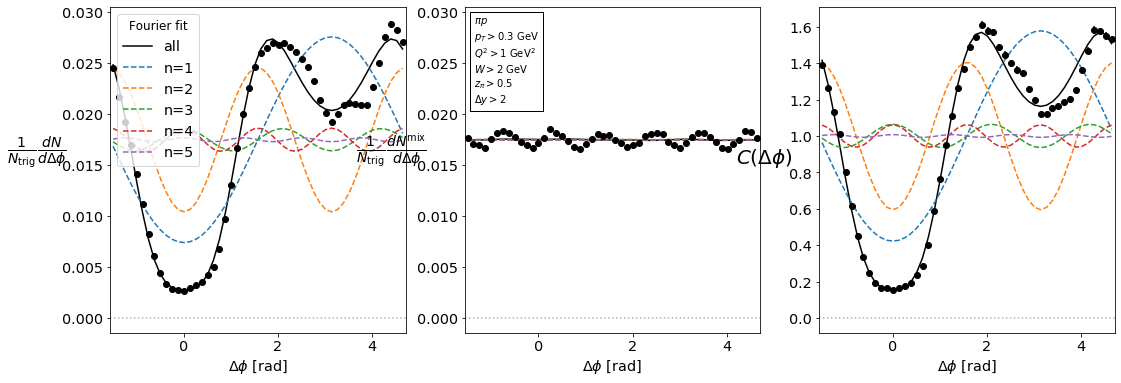

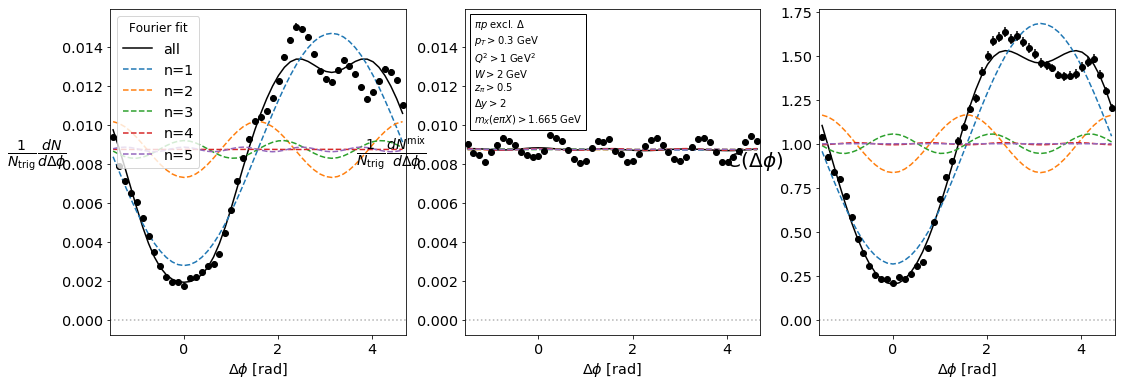

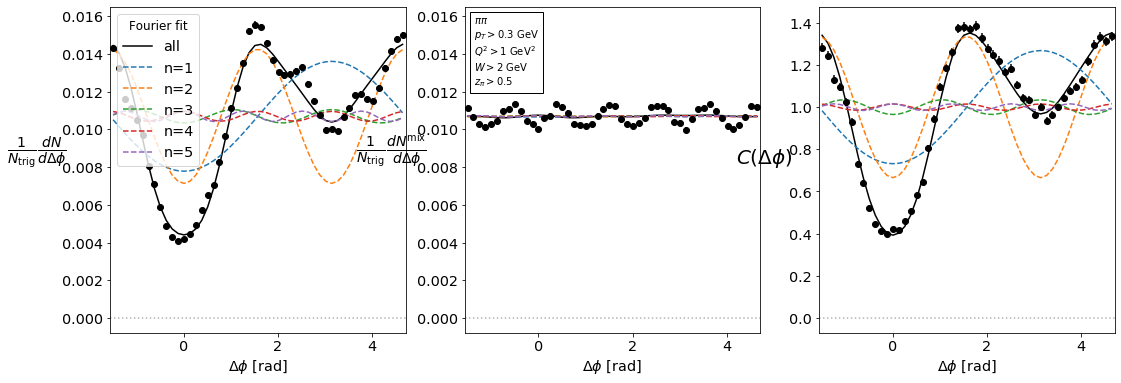

In [29]:
#lab frame
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab')
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$",loc='upper left'))
plt.show()

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and mx_eh1x > 1.665")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab')
axs[1].add_artist(AnchoredText("$\pi p$ excl. $\Delta$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$\n$\\Delta y>2$\n$m_X(e\\pi X)> 1.665$ GeV",loc='upper left'))
plt.show()

df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")
fig,axs = azimuthalPlot_3(df,df_trig,n=5,frame='lab')
axs[1].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.show()

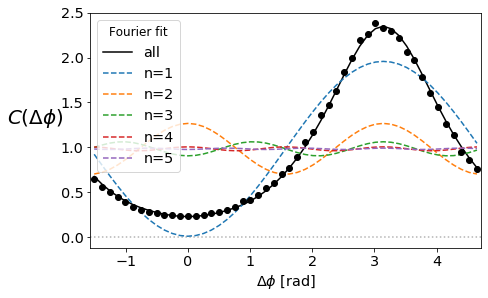

In [96]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")
azimuthalPlot(df,df_trig,n=5)

<ipython-input-24-e7abf3efcec0>:34: RuntimeWarning: invalid value encountered in true_divide
  dy = y/ym*np.hypot(dy/y, dym/ym)
<ipython-input-24-e7abf3efcec0>:35: RuntimeWarning: invalid value encountered in true_divide
  y= y/ym


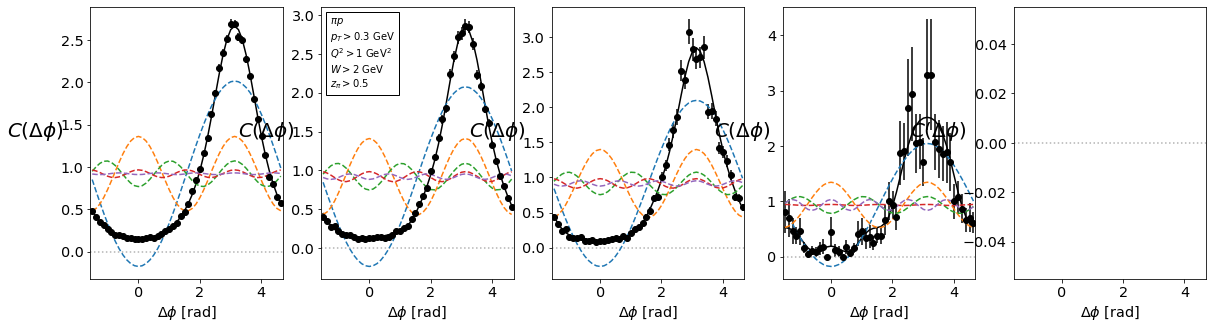

In [30]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 2212 and mx_eh1x >1.665")

partitions = [0.5, 0.6,0.7,0.8,0.9,1.0]
fig,axs = plt.subplots(1,len(partitions)-1,figsize=(20,5))
for i, (mn,mx) in enumerate(zip(partitions[:-1],partitions[1:])):
    dfbin = df.query('h1_z>%s and h1_z<%s'%(mn,mx))
    plt.sca(axs[i])
    azimuthalPlot(dfbin,df_trig,n=5,show='corr',includeLegend=False)
axs[1].add_artist(AnchoredText("$\pi p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.show()
            

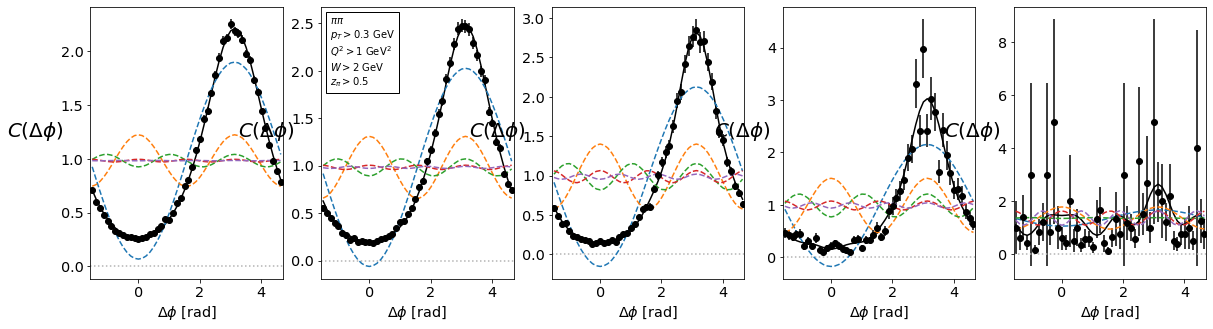

In [123]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and abs(h2_pid) == 211")

partitions = [0.5, 0.6,0.7,0.8,0.9,1.0]
fig,axs = plt.subplots(1,len(partitions)-1,figsize=(20,5))
for i, (mn,mx) in enumerate(zip(partitions[:-1],partitions[1:])):
    dfbin = df.query('h1_z>%s and h1_z<%s'%(mn,mx))
    plt.sca(axs[i])
    azimuthalPlot(dfbin,df_trig,n=5,show='corr',includeLegend=False)
axs[1].add_artist(AnchoredText("$\pi\pi$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.show()

<ipython-input-107-86d04697ff2b>:24: RuntimeWarning: invalid value encountered in true_divide
  dy = y/ym*np.hypot(dy/y, dym/ym)
<ipython-input-107-86d04697ff2b>:24: RuntimeWarning: divide by zero encountered in true_divide
  dy = y/ym*np.hypot(dy/y, dym/ym)
<ipython-input-107-86d04697ff2b>:25: RuntimeWarning: divide by zero encountered in true_divide
  y= y/ym
<ipython-input-107-86d04697ff2b>:37: RuntimeWarning: invalid value encountered in double_scalars
  b = [2*sum(y*np.cos(i*x))/len(x) for i in range(0,n+1)]


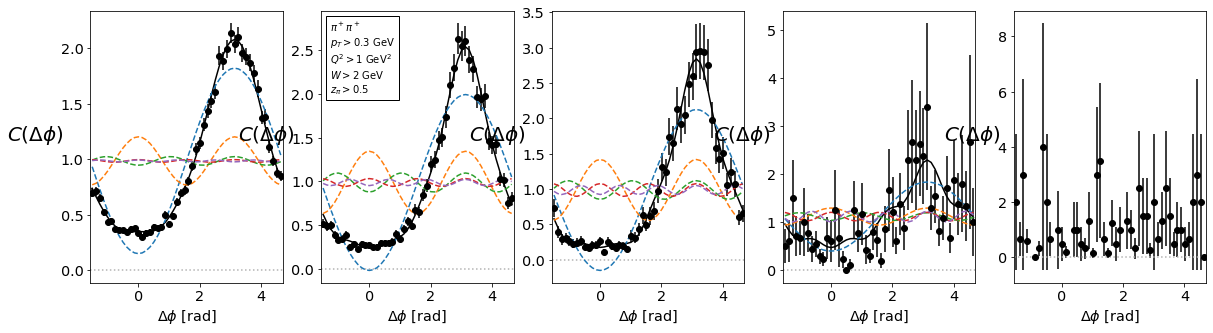

In [124]:
df = data_dihadrons.query("h1_cm_pt>0.3 and h2_cm_pt>0.3"\
                         + "and h2_pid == 211 and h1_pid == 211")

partitions = [0.5, 0.6,0.7,0.8,0.9,1.0]
fig,axs = plt.subplots(1,len(partitions)-1,figsize=(20,5))
for i, (mn,mx) in enumerate(zip(partitions[:-1],partitions[1:])):
    dfbin = df.query('h1_z>%s and h1_z<%s'%(mn,mx))
    plt.sca(axs[i])
    azimuthalPlot(dfbin,df_trig,n=5,show='corr',includeLegend=False)
axs[1].add_artist(AnchoredText("$\pi^+\pi^+$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
plt.show()

(array([      0.,       0.,       0.,       0.,       0., 1672821.,
              0.,       0.,       0.,       0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

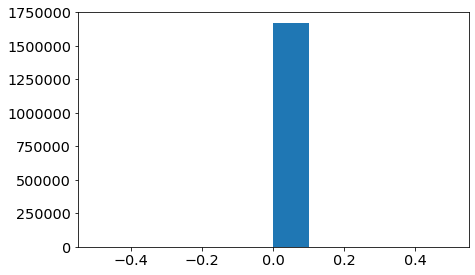